# CNN Image Classification Laboration


Images used in this laboration are from CIFAR 10 (https://en.wikipedia.org/wiki/CIFAR-10). The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Your task is to make a classifier, using a convolutional neural network, that can correctly classify each image into the correct class.

You need to answer all questions in this notebook. 

## Part 1: What is a convolution

To understand a bit more about convolutions, we will first test the convolution function in scipy using a number of classical filters. 

Convolve the image with Gaussian filter, a Sobel X filter, and a Sobel Y filter, using the function 'convolve2d' in 'signal' from scipy.

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.convolve2d.html

In a CNN, many filters are applied in each layer, and the filter coefficients are learned through back propagation.

In [1]:
from scipy import signal
import numpy as np

# Get a test image
from scipy import misc
image = misc.ascent()

# Define a help function for creating a Gaussian filter
def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

# Create Gaussian filter with certain size and standard deviation
gaussFilter = matlab_style_gauss2D((15,15),4)

# Define filter kernels for SobelX and Sobely
sobelX = np.array([[ 1, 0,  -1],
                    [2, 0, -2],
                    [1, 0, -1]]) 

sobelY = np.array([[ 1, 2,  1],
                    [0, 0, 0],
                    [-1, -2, -1]]) 

In [2]:
# Perform convolution using the function 'convolve2d' for the different filters
filterResponseGauss = signal.convolve2d(image, gaussFilter)
filterResponseSobelX = signal.convolve2d(image,sobelX)
filterResponseSobelY = signal.convolve2d(image,sobelY)

In [3]:
# Show filter responses
import matplotlib.pyplot as plt
fig, (ax_orig, ax_filt1, ax_filt2, ax_filt3) = plt.subplots(1, 4, figsize=(20, 6))
ax_orig.imshow(image, cmap='gray')
ax_orig.set_title('Original')
ax_orig.set_axis_off()
ax_filt1.imshow(np.absolute(filterResponseGauss), cmap='gray')
ax_filt1.set_title('Filter response')
ax_filt1.set_axis_off()
ax_filt2.imshow(np.absolute(filterResponseSobelX), cmap='gray')
ax_filt2.set_title('Filter response')
ax_filt2.set_axis_off()
ax_filt3.imshow(np.absolute(filterResponseSobelY), cmap='gray')
ax_filt3.set_title('Filter response')
ax_filt3.set_axis_off()

##  Part 2: Understanding convolutions

Question 1: What do the 3 different filters (Gaussian, SobelX, SobelY) do to the original image?

Gaussian filter transform the original matrix to a gaussian matrix with sigma=0.5, SobelX filter the orignal matrix with the matrix given by the defination, as for SobelY, it does the same thing but reverse the X and Y axis.

Question 2: What is the size of the original image? How many channels does it have? How many channels does a color image normally have?

The size of orignal image is (512,512) with two channels. Usually 3 channels, red green and blue.

Question 3: What is the size of the different filters?

For other two filters, the size are (514,514)

Question 4: What is the size of the filter response if mode 'same' is used for the convolution ?

The output is the same size as in1, centered with respect to the ‘full’ output.

Question 5: What is the size of the filter response if mode 'valid' is used for the convolution? How does the size of the valid filter response depend on the size of the filter? 

The output consists only of those elements that do not rely on the zero-padding. In ‘valid’ mode, either in1 or in2 must be at least as large as the other in every dimension.

The size of valid will be (Nf-1) pixels smaller

Question 6: Why are 'valid' convolutions a problem for CNNs with many layers?

We could run out of pixels eventually.

In [4]:
# Your code for checking sizes of image and filter responses
print("{} is the size of the original image".format(image.shape))
print("{} is the size of the response using gaussFilter".format(filterResponseGauss.shape))

print("{} is the size of the response using SobelX Filter".format(filterResponseSobelX.shape))
print("{} is the size of the response using SobelY Filter".format(filterResponseSobelY.shape))

(512, 512) is the size of the original image
(526, 526) is the size of the response using gaussFilter
(514, 514) is the size of the response using SobelX Filter
(514, 514) is the size of the response using SobelY Filter


##  Part 3: Get a graphics card

Let's make sure that our script can see the graphics card that will be used. The graphics cards will perform all the time consuming convolutions in every training iteration.

In [1]:
import os
import warnings

# Ignore FutureWarning from numpy
warnings.simplefilter(action='ignore', category=FutureWarning)

import keras.backend as K
import tensorflow as tf

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
 
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True) 

Using TensorFlow backend.


##  Part 4: How fast is the graphics card?

Lets investigate how much faster a convolution is with the graphics card

Question 7: Why are the filters of size 7 x 7 x 3, and not 7 x 7 ? 

With 3 channels

Question 8: What operation is performed by the 'Conv2D' layer? Is it a standard 2D convolution, as performed by the function signal.convolve2d we just tested?

'Conv2D' creates a convolution kernel that is convolved with the layer input to produce a tensor of outputs.

Question 9: How much faster is the graphics card, compared to the CPU, for convolving a batch of 100 images?

For 100 images per batch, GPU is 5 times faster than CPU

Question 10: How much faster is the graphics card, compared to the CPU, for convolving a batch of 2 images? Explain the difference compared to 100 images.

With 2 images per batch, GPU is only a little bit faster than CPU, that's because a batch of 2 images can't have 100% utilization of GPU.

In [2]:
# Run this cell to compare processing time of CPU and GPU

import timeit

n_images_in_batch = 100

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs. 100 images per batch')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))


n_images_in_batch = 2

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

# Perform convolutions using the CPU
def cpu():
  with tf.device('/cpu:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_cpu)

# Perform convolutions using the GPU (graphics card)
def gpu():
  with tf.device('/device:GPU:0'):
    random_images = tf.random.normal((n_images_in_batch, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_images)
    return tf.math.reduce_sum(net_gpu)

# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the convolution several times and measure the time
print('Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3'
      ' (batch x height x width x channel). Sum of ten runs. 2 images per batch')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3 (batch x height x width x channel). Sum of ten runs. 100 images per batch
CPU (s):
0.9845428400000173
GPU (s):
0.19714656700000432
GPU speedup over CPU: 4x
Time (s) to convolve 32 filters of size 7 x 7 x 3 over 100 random images of size 100 x 100 x 3 (batch x height x width x channel). Sum of ten runs. 2 images per batch
CPU (s):
0.08663913399999501
GPU (s):
0.053993371000046864
GPU speedup over CPU: 1x


##  Part 5:  Load data
Time to make a 2D CNN. Load the images and labels from keras.datasets, this cell is already finished.

In [4]:
from keras.datasets import cifar10
import numpy as np

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Download CIFAR train and test data
(Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()

print("Training images have size {} and labels have size {} ".format(Xtrain.shape, Ytrain.shape))
print("Test images have size {} and labels have size {} \n ".format(Xtest.shape, Ytest.shape))

# Reduce the number of images for training and testing to 10000 and 2000 respectively, 
# to reduce processing time for this laboration
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

Xtest = Xtest[0:2000]
Ytest = Ytest[0:2000]

Ytestint = Ytest

print("Reduced training images have size %s and labels have size %s " % (Xtrain.shape, Ytrain.shape))
print("Reduced test images have size %s and labels have size %s \n" % (Xtest.shape, Ytest.shape))

# Check that we have some training examples from each class
for i in range(10):
    print("Number of training examples for class {} is {}" .format(i,np.sum(Ytrain == i)))

Training images have size (50000, 32, 32, 3) and labels have size (50000, 1) 
Test images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
 
Reduced training images have size (10000, 32, 32, 3) and labels have size (10000, 1) 
Reduced test images have size (2000, 32, 32, 3) and labels have size (2000, 1) 

Number of training examples for class 0 is 1005
Number of training examples for class 1 is 974
Number of training examples for class 2 is 1032
Number of training examples for class 3 is 1016
Number of training examples for class 4 is 999
Number of training examples for class 5 is 937
Number of training examples for class 6 is 1030
Number of training examples for class 7 is 1001
Number of training examples for class 8 is 1025
Number of training examples for class 9 is 981


##  Part 6: Plotting

Lets look at some of the training examples, this cell is already finished. You will see different examples every time you run the cell.

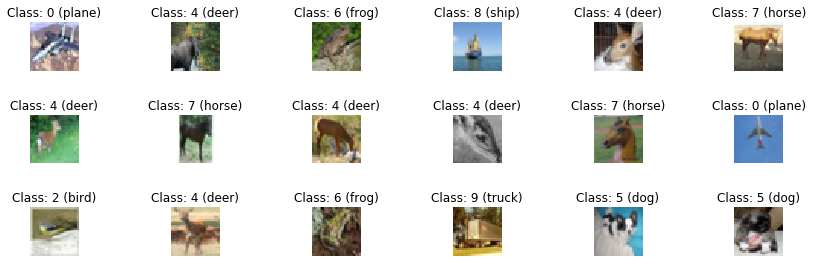

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
for i in range(18):
    idx = np.random.randint(7500)
    label = Ytrain[idx,0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(Xtrain[idx])
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

##   Part 7: Split data into training, validation and testing
Split your training data into training (Xtrain, Ytrain) and validation (Xval, Yval), so that we have training, validation and test datasets (as in the previous laboration). We use a function in scikit learn. Use 25% of the data for validation.

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [5]:
from sklearn.model_selection import train_test_split

Xtrain, Xval, Ytrain, Yval = train_test_split(Xtrain, Ytrain, test_size = 0.25, random_state = 1)
print("The size of the training data-- X:{}, Y:{}".format(Xtrain.shape, Ytrain.shape))
print("The size of the validation data-- X:{}, Y:{}".format(Xval.shape, Yval.shape))
print("The size of the test data-- X:{}, Y:{}".format(Xtest.shape, Ytest.shape))

# Print the size of training data, validation data and test data
#print('The validation and test data have size {}, {}, {} and {}'.format(Xval.shape, Xtest.shape, Yval.shape, Ytest.shape))

The size of the training data-- X:(7500, 32, 32, 3), Y:(7500, 1)
The size of the validation data-- X:(2500, 32, 32, 3), Y:(2500, 1)
The size of the test data-- X:(2000, 32, 32, 3), Y:(2000, 1)


##  Part 8: Preprocessing of images

Lets perform some preprocessing. The images are stored as uint8, i.e. 8 bit unsigned integers, but need to be converted to 32 bit floats. We also make sure that the range is -1 to 1, instead of 0 - 255. This cell is already finished.

In [6]:
# Convert datatype for Xtrain, Xval, Xtest, to float32
Xtrain = Xtrain.astype('float32')
Xval = Xval.astype('float32')
Xtest = Xtest.astype('float32')

# Change range of pixel values to [-1,1]
Xtrain = Xtrain / 127.5 - 1
Xval = Xval / 127.5 - 1
Xtest = Xtest / 127.5 - 1

##  Part 9: Preprocessing of labels

The labels (Y) need to be converted from e.g. '4' to "hot encoded", i.e. to a vector of type [0, 0, 0, 1, 0, 0, 0, 0, 0, 0] . We use a function in Keras, see https://keras.io/utils/#to_categorical

In [7]:
from keras.utils import to_categorical

# Print shapes before converting the labels
print("The shapes of the labels are {}, {}, {} for training, validation and test data, respectively.".format(Ytrain.shape, Yval.shape, Ytest.shape))

# Your code for converting Ytrain, Yval, Ytest to categorical
Ytrain=to_categorical(Ytrain)
Ytest=to_categorical(Ytest)
Yval=to_categorical(Yval)
# Print shapes after converting the labels
print("The shapes of the converted labels are {}, {}, {} for training, validation and test data, respectively.".format(Ytrain.shape, Yval.shape, Ytest.shape))


The shapes of the labels are (7500, 1), (2500, 1), (2000, 1) for training, validation and test data, respectively.
The shapes of the converted labels are (7500, 10), (2500, 10), (2000, 10) for training, validation and test data, respectively.


##  Part 10: 2D CNN
Finish this code to create the image classifier, using a 2D CNN. Each convolutional layer will contain 2D convolution, batch normalization and max pooling. After the convolutional layers comes a flatten layer and a number of intermediate dense layers. The convolutional layers should take the number of filters as an argument, use a kernel size of 3 x 3, 'same' padding, and relu activation functions. The number of filters will double with each convolutional layer. The max pooling layers should have a pool size of 2 x 2. The intermediate dense layers before the final dense layer should take the number of nodes as an argument, use relu activation functions, and be followed by batch normalization. The final dense layer should have 10 nodes (= the number of classes in this laboration) and 'softmax' activation. Here we start with the Adam optimizer.

Relevant functions are

`model.add()`, adds a layer to the network

`Dense()`, a dense network layer

`Conv2D()`, performs 2D convolutions with a number of filters with a certain size (e.g. 3 x 3). 

`BatchNormalization()`, perform batch normalization

`MaxPooling2D()`, saves the max for a given pool size, results in down sampling

`Flatten()`, flatten a multi-channel tensor into a long vector

`model.compile()`, compile the model, add " metrics=['accuracy'] " to print the classification accuracy during the training

See https://keras.io/layers/core/ for information on how the `Dense()` and `Flatten()` functions work

See https://keras.io/layers/convolutional/ for information on how `Conv2D()` works

See https://keras.io/layers/pooling/ for information on how `MaxPooling2D()` works

Import a relevant cost function for multi-class classification from keras.losses (https://keras.io/losses/)

See https://keras.io/models/model/ for how to compile, train and evaluate the model

In [8]:
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy as CC

# Set seed from random number generator, for better comparisons
from numpy.random import seed
seed(123)

def build_CNN(input_shape, n_conv_layers=2, n_filters=16, n_dense_layers=0, n_nodes=50, use_dropout=False, learning_rate=0.01):

    # Setup a sequential model
    model = Sequential()
    opt=Adam(learning_rate=learning_rate)
    # Add first convolutional layer to the model, requires input shape
    conv_layer=Conv2D(n_filters,kernel_size=(3,3),padding="same",activation="relu",input_shape=input_shape)
    model.add(conv_layer)
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    # Add remaining convolutional layers to the model, the number of filters should increase a factor 2 for each layer
    for i in range(n_conv_layers-1):
        another_conv_layer=Conv2D((2**(i+1))*n_filters,kernel_size=(3,3),padding="same",activation="relu")
        model.add(another_conv_layer)
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2,2)))
        
    # Add flatten layer
    model.add(Flatten())
    
    # Add intermediate dense layers
    for i in range(n_dense_layers):
        model.add(Dense(units=n_nodes,activation="relu"))
        model.add(BatchNormalization())
        if use_dropout:
            model.add(Dropout(0.5))
            
    # Add final dense layer
    model.add(Dense(units=10,activation="softmax"))
    
    # Compile model
    model.compile(loss=CC(), optimizer=opt, metrics=['accuracy'])
    return model

In [9]:
# Lets define a help function for plotting the training results
import matplotlib.pyplot as plt
def plot_results(history):
    
    loss = history.history['loss']
    acc = history.history['accuracy']
    val_loss = history.history['val_loss']
    val_acc = history.history['val_accuracy']
    
    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training','Validation'])

    plt.figure(figsize=(10,4))
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(acc)
    plt.plot(val_acc)
    plt.legend(['Training','Validation'])

    plt.show()

## Part 11: Train 2D CNN

Time to train the 2D CNN, start with 2 convolutional layers, no intermediate dense layers, learning rate = 0.01. The first convolutional layer should have 16 filters (which means that the second convolutional layer will have 32 filters).

Relevant functions

`build_CNN`, the function we defined in Part 10, call it with the parameters you want to use

`model.fit()`, train the model with some training data

`model.evaluate()`, apply the trained model to some test data

## 2 convolutional layers, no intermediate dense layers

In [15]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (32,32,3)

# Build model
model1 = build_CNN(input_shape,n_conv_layers=2,n_dense_layers=0)

# Train the model  using training data and validation data
history1 = model1.fit(Xtrain,Ytrain,epochs=epochs,batch_size=batch_size,validation_data=(Xval,Yval))

Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 3s 366us/step - loss: 2.8799 - accuracy: 0.3281 - val_loss: 2.0303 - val_accuracy: 0.3364
Epoch 2/20
7500/7500 [==============================] - 1s 139us/step - loss: 1.5353 - accuracy: 0.4791 - val_loss: 1.5751 - val_accuracy: 0.4244
Epoch 3/20
7500/7500 [==============================] - 1s 140us/step - loss: 1.2308 - accuracy: 0.5604 - val_loss: 1.6243 - val_accuracy: 0.4244
Epoch 4/20
7500/7500 [==============================] - 1s 139us/step - loss: 1.0979 - accuracy: 0.6155 - val_loss: 1.4896 - val_accuracy: 0.4728
Epoch 5/20
7500/7500 [==============================] - 1s 139us/step - loss: 0.9740 - accuracy: 0.6532 - val_loss: 1.3792 - val_accuracy: 0.5268
Epoch 6/20
7500/7500 [==============================] - 1s 138us/step - loss: 0.8909 - accuracy: 0.6849 - val_loss: 1.3548 - val_accuracy: 0.5448
Epoch 7/20
7500/7500 [==============================] - 1s 139us/step - loss

In [16]:
# Evaluate model on test data
score = model1.evaluate(Xtest,Ytest,batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 63us/step
Test loss: 2.9125
Test accuracy: 0.5475


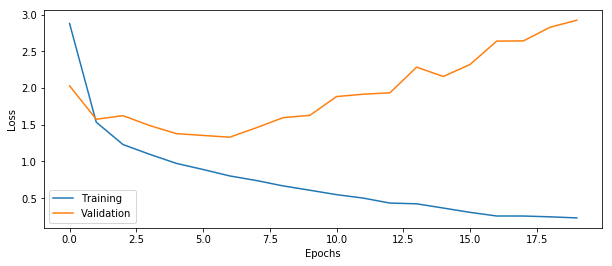

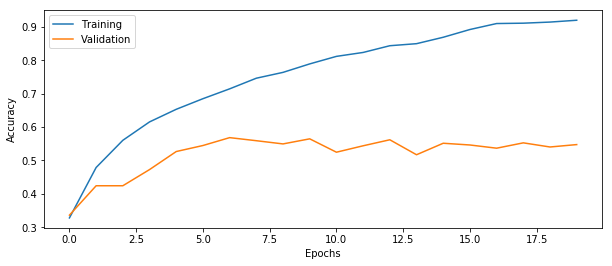

In [17]:
# Plot the history from the training run
plot_results(history1)

## Part 12: Improving performance
Write down the test accuracy, are you satisfied with the classifier performance (random chance is 10%) ? 

Question 11: How big is the difference between training and test accuracy?

Training accuracy: 92%

Test accuracy: 55%

Difference could up to 37%

Question 12: How busy is the GPU for a batch size of 100? How much GPU memory is used? Hint: run 'watch nvidia-smi' on the cloud computer during training.  -- 11023MiB

Question 13: For the DNN laboration we used a batch size of 10,000, why do we need to use a smaller batch size in this laboration?

There's only 10000 training sample in this lab; the size of training data is smaller in this laboration

## 2 convolutional layers, 1 intermediate dense layer (50 nodes)

In [18]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (32,32,3)

# Build model
model2 = build_CNN(input_shape,n_conv_layers=2,n_dense_layers=1,n_nodes=50)

# Train the model  using training data and validation data
history2 = model2.fit(Xtrain,Ytrain,epochs=epochs,batch_size=batch_size,validation_data=(Xval,Yval))


Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 2s 299us/step - loss: 1.6042 - accuracy: 0.4271 - val_loss: 1.9593 - val_accuracy: 0.2892
Epoch 2/20
7500/7500 [==============================] - 1s 166us/step - loss: 1.2466 - accuracy: 0.5521 - val_loss: 2.3353 - val_accuracy: 0.2988
Epoch 3/20
7500/7500 [==============================] - 1s 151us/step - loss: 1.0205 - accuracy: 0.6357 - val_loss: 1.7424 - val_accuracy: 0.4024
Epoch 4/20
7500/7500 [==============================] - 1s 165us/step - loss: 0.8626 - accuracy: 0.6961 - val_loss: 1.3944 - val_accuracy: 0.5264
Epoch 5/20
7500/7500 [==============================] - 1s 150us/step - loss: 0.6920 - accuracy: 0.7563 - val_loss: 1.4711 - val_accuracy: 0.5540
Epoch 6/20
7500/7500 [==============================] - 1s 164us/step - loss: 0.5571 - accuracy: 0.8023 - val_loss: 1.6802 - val_accuracy: 0.5520
Epoch 7/20
7500/7500 [==============================] - 1s 171us/step - loss

In [19]:
# Evaluate the trained model on test set, not used in training or validation
score = model2.evaluate(Xtest,Ytest,batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 69us/step
Test loss: 3.0401
Test accuracy: 0.5450


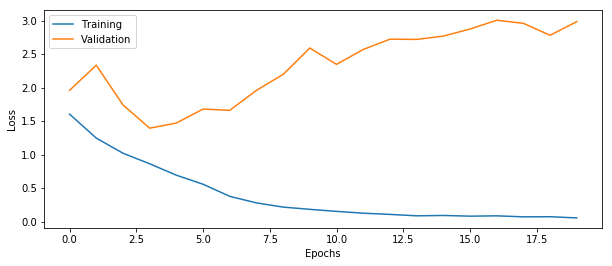

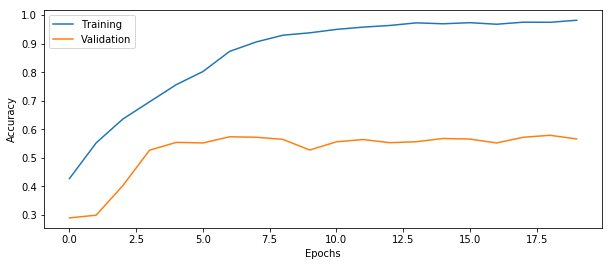

In [20]:
# Plot the history from the training run
plot_results(history2)

## 4 convolutional layers, 1 intermediate dense layer (50 nodes)

In [12]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (32,32,3)

# Build model
model3 = build_CNN(input_shape,n_conv_layers=4,n_dense_layers=1,n_nodes=50)

# Train the model  using training data and validation data
history3 = model3.fit(Xtrain,Ytrain,epochs=epochs,batch_size=batch_size,validation_data=(Xval,Yval))


Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 3s 438us/step - loss: 1.7193 - accuracy: 0.3773 - val_loss: 2.4596 - val_accuracy: 0.2452
Epoch 2/20
7500/7500 [==============================] - 2s 228us/step - loss: 1.3747 - accuracy: 0.4900 - val_loss: 2.5557 - val_accuracy: 0.2728
Epoch 3/20
7500/7500 [==============================] - 2s 231us/step - loss: 1.1826 - accuracy: 0.5681 - val_loss: 1.7861 - val_accuracy: 0.3992
Epoch 4/20
7500/7500 [==============================] - 2s 232us/step - loss: 1.0307 - accuracy: 0.6276 - val_loss: 1.5558 - val_accuracy: 0.5144
Epoch 5/20
7500/7500 [==============================] - 2s 217us/step - loss: 0.8515 - accuracy: 0.7025 - val_loss: 1.6667 - val_accuracy: 0.5348
Epoch 6/20
7500/7500 [==============================] - 2s 234us/step - loss: 0.7146 - accuracy: 0.7440 - val_loss: 1.5350 - val_accuracy: 0.5672
Epoch 7/20
7500/7500 [==============================] - 2s 231us/step - loss

In [13]:
# Evaluate the trained model on test set, not used in training or validation
score = model3.evaluate(Xtest,Ytest,batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 65us/step
Test loss: 2.8714
Test accuracy: 0.5625


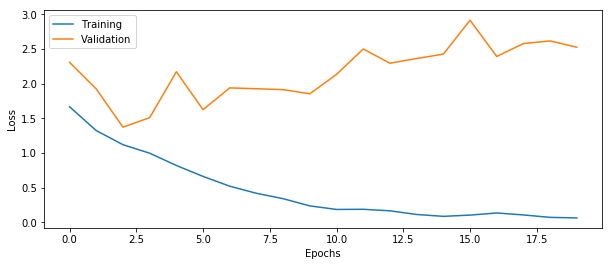

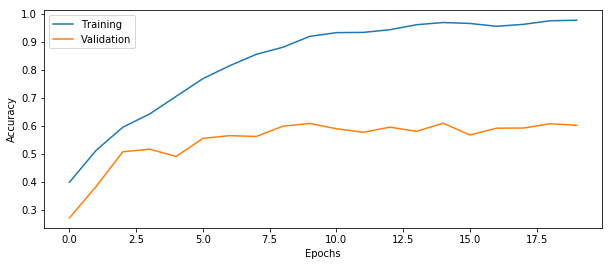

In [25]:
# Plot the history from the training run
plot_results(history3)

##  Part 13: Plot the CNN architecture

To understand your network better, print the architecture using `model.summary()`

Question 14: How many trainable parameters does your network have? Which part of the network contains most of the parameters?

123,700 trainable parameters.

The last convolutional layer has the most parameters.
 
Question 15: What is the input to and output of a Conv2D layer? What are the dimensions of the input and output? 

Input (batch_size, channels, rows, cols)

Output (batch_size, filters, new_rows, new_cols)

4 dimensions

Question 16: Is the batch size always the first dimension of each 4D tensor? Check the documentation for Conv2D, https://keras.io/layers/convolutional/

Yes, according to documentation:

4D tensor with shape: (batch_size, filters, new_rows, new_cols) if data_format='channels_first' or 4D tensor with shape: (batch_size, new_rows, new_cols, filters) if data_format='channels_last'. rows and cols values might have changed due to padding.

Question 17: If a convolutional layer that contains 128 filters is applied to an input with 32 channels, what is the number of channels in the output?

128

Question 18: Why is the number of parameters in each Conv2D layer *not* equal to the number of filters times the number of filter coefficients per filter (plus biases)?

For convolutional layers, numbers of parameters= output_channel*(input_channel*(rows*cols)+1)

Question 19: How does MaxPooling help in reducing the number of parameters to train?

By taking the maximum value over the window defined by pool_size for each dimension along the features axis.

In [26]:
# Print network architecture

model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
batch_normalization_11 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 32)        4640      
_________________________________________________________________
batch_normalization_12 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 32)          0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 8, 8, 64)         

##  Part 14: Dropout regularization

Add dropout regularization to each intermediate dense layer, dropout probability 50%.

Question 20: How much did the test accuracy improve with dropout, compared to without dropout?

Without Dropout: 56%

With Dropout: 60%

The test accuracy is improved by 4%.

Question 21: What other types of regularization can be applied? How can you add L2 regularization for the convolutional layers?

Available regularizers: l1,l2,l1_l2

Import l2 regularizer from keras.regularizers, create and put it in the decleration of the layer statement.

## 4 convolutional layers, 1 intermediate dense layer (50 nodes), dropout

In [10]:
# Setup some training parameters
batch_size = 100
epochs = 20
input_shape = (32,32,3)

# Build model
model4 = build_CNN(input_shape,n_conv_layers=4,n_dense_layers=1,n_nodes=50,use_dropout=True)

# Train the model  using training data and validation data
history4 = model4.fit(Xtrain,Ytrain,epochs=epochs,batch_size=batch_size,validation_data=(Xval,Yval))


Train on 7500 samples, validate on 2500 samples
Epoch 1/20
7500/7500 [==============================] - 4s 590us/step - loss: 2.0148 - accuracy: 0.2944 - val_loss: 1.7077 - val_accuracy: 0.3620
Epoch 2/20
7500/7500 [==============================] - 2s 231us/step - loss: 1.6005 - accuracy: 0.4011 - val_loss: 1.5615 - val_accuracy: 0.4292
Epoch 3/20
7500/7500 [==============================] - 2s 221us/step - loss: 1.4482 - accuracy: 0.4681 - val_loss: 1.6278 - val_accuracy: 0.4368
Epoch 4/20
7500/7500 [==============================] - 2s 229us/step - loss: 1.3298 - accuracy: 0.5125 - val_loss: 1.4039 - val_accuracy: 0.5008
Epoch 5/20
7500/7500 [==============================] - 2s 233us/step - loss: 1.2078 - accuracy: 0.5612 - val_loss: 1.4735 - val_accuracy: 0.4912
Epoch 6/20
7500/7500 [==============================] - 2s 230us/step - loss: 1.1152 - accuracy: 0.6032 - val_loss: 1.5985 - val_accuracy: 0.5116
Epoch 7/20
7500/7500 [==============================] - 2s 235us/step - loss

In [11]:
# Evaluate the trained model on test set, not used in training or validation
score = model4.evaluate(Xtest,Ytest,batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 81us/step
Test loss: 2.0764
Test accuracy: 0.6040


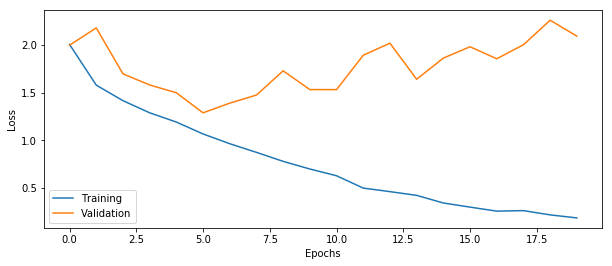

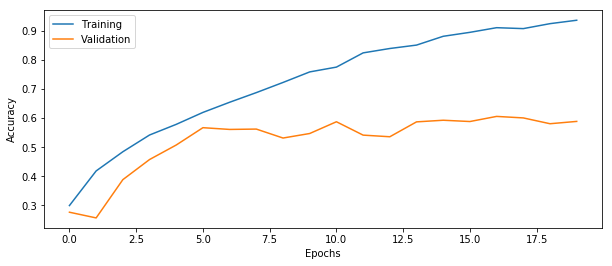

In [29]:
# Plot the history from the training run
plot_results(history4)

##  Part 15: Tweaking performance

You have now seen the basic building blocks of a 2D CNN. To further improve performance involves changing the number of convolutional layers, the number of filters per layer, the number of intermediate dense layers, the number of nodes in the intermediate dense layers, batch size, learning rate, number of epochs, etc. Spend some time (30 - 90 minutes) testing different settings.

Question 22: How high test accuracy can you obtain? What is your best configuration?

64% of test accuracy.
with:
batch_size = 50

epochs = 40

input_shape = (32,32,3)

32 filters per layer, 4 convolutional layers, 1 intermediate dense layer, and 50 nodes

## Your best config

In [30]:
# Setup some training parameters
batch_size = 50
epochs = 40
input_shape = (32,32,3)
# Build model
model5 =build_CNN(input_shape,n_filters=32,n_conv_layers=4,n_dense_layers=1,n_nodes=50,learning_rate=0.01,use_dropout=True)

# Train the model  using training data and validation data
history5 = model5.fit(Xtrain,Ytrain,epochs=epochs,batch_size=batch_size,validation_data=(Xval,Yval), verbose = 0)


In [31]:
# Evaluate the trained model on test set, not used in training or validation
score = model5.evaluate(Xtest,Ytest,batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 156us/step
Test loss: 2.1688
Test accuracy: 0.6440


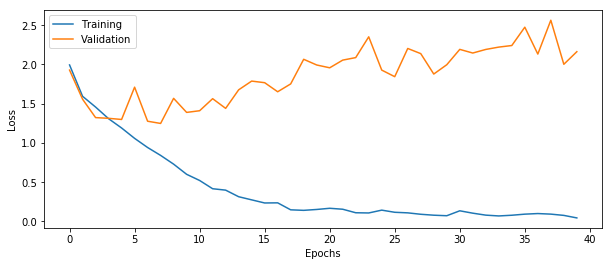

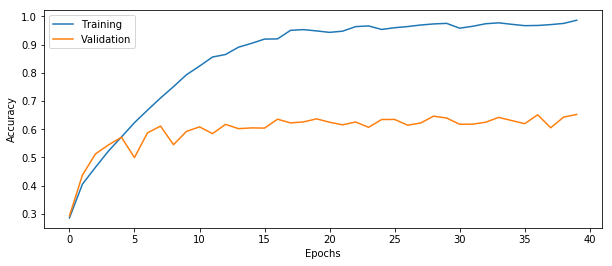

In [32]:
# Plot the history from the training run
plot_results(history5)

##  Part 16: Rotate the test images

How high is the test accuracy if we rotate the test images? In other words, how good is the CNN at generalizing to rotated images?

Rotate each test image 90 degrees, the cells are already finished.

Question 23: What is the test accuracy for rotated test images, compared to test images without rotation? Explain the difference in accuracy.

22% of test accuracy, the model is trained with images that is not rotated and the original images has a larger response in pooling unit. Although the best configurations are used, the test accuracy would decrease.

In [33]:
def myrotate(images):

    images_rot = np.rot90(images, axes=(1,2))
    
    return images_rot

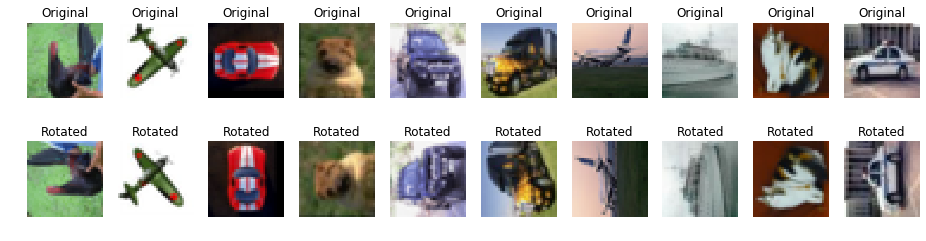

In [34]:
# Rotate the test images 90 degrees
Xtest_rotated = myrotate(Xtest)

# Look at some rotated images
plt.figure(figsize=(16,4))
for i in range(10):
    idx = np.random.randint(500)
    
    plt.subplot(2,10,i+1)
    plt.imshow(Xtest[idx]/2+0.5)
    plt.title("Original")
    plt.axis('off')
    
    plt.subplot(2,10,i+11)
    plt.imshow(Xtest_rotated[idx]/2+0.5)
    plt.title("Rotated")
    plt.axis('off')
plt.show()


In [35]:
# Evaluate the trained model on rotated test set
score = model5.evaluate(Xtest_rotated,Ytest,batch_size)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

2000/2000 [==============================] - 0s 221us/step
Test loss: 6.9866
Test accuracy: 0.2230


##  Part 17: Augmentation using Keras `ImageDataGenerator`

We can increase the number of training images through data augmentation (we now ignore that CIFAR10 actually has 60 000 training images). Image augmentation is about creating similar images, by performing operations such as rotation, scaling, elastic deformations and flipping of existing images. This will prevent overfitting, especially if all the training images are in a certain orientation.

We will perform the augmentation on the fly, using a built-in function in Keras, called `ImageDataGenerator`

See https://keras.io/preprocessing/image/

In [36]:
# Get all 60 000 training images again. ImageDataGenerator manages validation data on its own
# (Xtrain, Ytrain), (Xtest, Ytest) = cifar10.load_data()
(Xtrain, Ytrain), _ = cifar10.load_data()
# Reduce number of images to 10,000
Xtrain = Xtrain[0:10000]
Ytrain = Ytrain[0:10000]

# Xtest = Xtest[0:2000]
# Ytest = Ytest[0:2000]

# Change data type and rescale range
Xtrain = Xtrain.astype('float32')
Xtrain = Xtrain / 127.5 - 1
# Xtest = Xtest.astype('float32')
# Xtest = Xtest / 127.5 - 1
# Convert labels to hot encoding
Ytrain = to_categorical(Ytrain, 10)
# Ytest = to_categorical(Ytest, 10)

In [37]:
from keras.preprocessing.image import ImageDataGenerator
# Set up a data generator with on-the-fly data augmentation, 20% validation split
datagen=ImageDataGenerator(
    validation_split=0.2,
    # Use a rotation range of 30 degrees, horizontal and vertical flipping
    rotation_range=30,
    horizontal_flip=True,
    vertical_flip=True
)

# Setup a flow for training data, assume that we can fit all images into CPU memory
train_flow=datagen.flow(Xtrain,Ytrain,subset="training")
# Setup a flow for validation data, assume that we can fit all images into CPU memory
val_flow=datagen.flow(Xtrain,Ytrain,subset="validation")

## Part 18: What about big data?

Question 24: How would you change the code for the image generator if you cannot fit all training images in CPU memory? What is the disadvantage of doing that change?

By shrinking the size of images. Lower resolution images may lead to a lower accuracy.

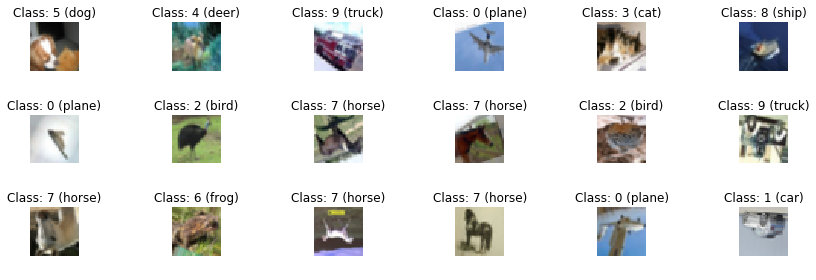

In [38]:
# Plot some augmented images
plot_datagen = datagen.flow(Xtrain, Ytrain, batch_size=1)

plt.figure(figsize=(12,4))
for i in range(18):
    (im, label) = plot_datagen.next()
    im = (im[0] + 1) * 127.5
    im = im.astype('int')
    label = np.flatnonzero(label)[0]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.title("Class: {} ({})".format(label, classes[label]))
    plt.axis('off')
plt.show()

## Part 19: Train the CNN with images from the generator

See https://keras.io/models/model/ for how to use model.fit_generator instead of model.fit for training

To make the comparison fair to training without augmentation

    steps_per_epoch should be set to: len(Xtrain)*(1 - validation_split)/batch_size

    validation_steps should be set to: len(Xtrain)*validation_split/batch_size

Question 25: How quickly is the training accuracy increasing compared to without augmentation? Explain why there is a difference compared to without augmentation. What parameter is necessary to change to perform more training?

The training accracy increases much more slower than the training without augmentation. For each epoch, we need to reprocess our training and validation data, that will took more time compared to without augmentation. 

steps_per_epoch, validation_steps and epochs

Question 26: What other types of image augmentation can be applied, compared to what we use here?

Parameters list from documentation, which includes all augmentation we can applied to our data:
    featurewise_center,
    samplewise_center,
    featurewise_std_normalization,
    samplewise_std_normalization,
    zca_whitening,
    zca_epsilon,
    rotation_range,
    width_shift_range,
    height_shift_range,
    brightness_range,
    shear_range,
    zoom_range,
    channel_shift_range,
    fill_mode,
    cval,
    horizontal_flip,
    vertical_flip,
    rescale,

In [40]:
# Setup some training parameters
batch_size = 100
epochs = 200
input_shape = (32,32,3)

# Build model (your best config)
model6 = build_CNN(input_shape,n_filters=32,n_conv_layers=4,n_dense_layers=1,n_nodes=50,learning_rate=0.01,use_dropout=True)

validation_split=0.2
    
# Train the model using on the fly augmentation
#history6 = model6.fit(Xtrain,Ytrain,epochs=epochs,batch_size=batch_size,validation_data=(Xval,Yval))
history6 = model6.fit_generator(train_flow,epochs=epochs,steps_per_epoch=len(Xtrain)*(1 - validation_split)/batch_size,validation_data=val_flow,validation_steps=len(Xtrain)*validation_split/batch_size)

Epoch 1/200
80/80 [==============================] - 3s 42ms/step - loss: 2.4392 - accuracy: 0.1754 - val_loss: 2.1267 - val_accuracy: 0.2625
Epoch 2/200
80/80 [==============================] - 2s 21ms/step - loss: 2.0439 - accuracy: 0.2379 - val_loss: 2.0461 - val_accuracy: 0.2812
Epoch 3/200
80/80 [==============================] - 2s 20ms/step - loss: 1.9213 - accuracy: 0.2816 - val_loss: 1.7231 - val_accuracy: 0.2453
Epoch 4/200
80/80 [==============================] - 2s 22ms/step - loss: 1.8436 - accuracy: 0.3039 - val_loss: 1.8152 - val_accuracy: 0.3061
Epoch 5/200
80/80 [==============================] - 2s 20ms/step - loss: 1.8421 - accuracy: 0.3051 - val_loss: 2.6755 - val_accuracy: 0.1906
Epoch 6/200
80/80 [==============================] - 2s 21ms/step - loss: 1.7840 - accuracy: 0.3375 - val_loss: 1.9525 - val_accuracy: 0.3656
Epoch 7/200
80/80 [==============================] - 2s 22ms/step - loss: 1.7699 - accuracy: 0.3453 - val_loss: 1.5442 - val_accuracy: 0.3654
Epoch 

80/80 [==============================] - 2s 19ms/step - loss: 0.9172 - accuracy: 0.6855 - val_loss: 1.4021 - val_accuracy: 0.6328
Epoch 116/200
80/80 [==============================] - 2s 21ms/step - loss: 0.9300 - accuracy: 0.6805 - val_loss: 1.0552 - val_accuracy: 0.5984
Epoch 117/200
80/80 [==============================] - 2s 22ms/step - loss: 0.9139 - accuracy: 0.6785 - val_loss: 1.4866 - val_accuracy: 0.6298
Epoch 118/200
80/80 [==============================] - 2s 20ms/step - loss: 0.9185 - accuracy: 0.6750 - val_loss: 0.9805 - val_accuracy: 0.6203
Epoch 119/200
80/80 [==============================] - 2s 20ms/step - loss: 0.9076 - accuracy: 0.6863 - val_loss: 1.1840 - val_accuracy: 0.6516
Epoch 120/200
80/80 [==============================] - 2s 21ms/step - loss: 0.8685 - accuracy: 0.7031 - val_loss: 0.9662 - val_accuracy: 0.6619
Epoch 121/200
80/80 [==============================] - 2s 21ms/step - loss: 0.9247 - accuracy: 0.6777 - val_loss: 0.8154 - val_accuracy: 0.6422
Epoch 

Epoch 172/200
80/80 [==============================] - 2s 20ms/step - loss: 0.7508 - accuracy: 0.7414 - val_loss: 1.2507 - val_accuracy: 0.6609
Epoch 173/200
80/80 [==============================] - 2s 20ms/step - loss: 0.6884 - accuracy: 0.7641 - val_loss: 1.0207 - val_accuracy: 0.6344
Epoch 174/200
80/80 [==============================] - 2s 22ms/step - loss: 0.7158 - accuracy: 0.7434 - val_loss: 1.0964 - val_accuracy: 0.6554
Epoch 175/200
80/80 [==============================] - 2s 21ms/step - loss: 0.7742 - accuracy: 0.7234 - val_loss: 1.0622 - val_accuracy: 0.6578
Epoch 176/200
80/80 [==============================] - 2s 19ms/step - loss: 0.7244 - accuracy: 0.7563 - val_loss: 0.7320 - val_accuracy: 0.6781
Epoch 177/200
80/80 [==============================] - 2s 22ms/step - loss: 0.7400 - accuracy: 0.7492 - val_loss: 1.0942 - val_accuracy: 0.6314
Epoch 178/200
80/80 [==============================] - 2s 21ms/step - loss: 0.7359 - accuracy: 0.7414 - val_loss: 0.9745 - val_accuracy:

In [41]:
# Check if there is still a big difference in accuracy for original and rotated test images

# Evaluate the trained model on original test set
score = model6.evaluate(Xtest, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

# Evaluate the trained model on rotated test set
score = model6.evaluate(Xtest_rotated, Ytest, batch_size = batch_size, verbose=0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 1.1041
Test accuracy: 0.6525
Test loss: 2.6713
Test accuracy: 0.3300


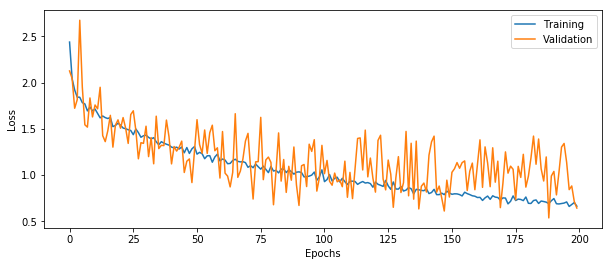

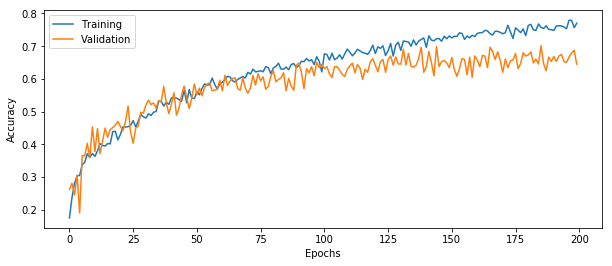

In [42]:
# Plot the history from the training run
plot_results(history6)

## Part 20: Plot misclassified images

Lets plot some images where the CNN performed badly

In [43]:
# Find misclassified images
y_pred = model6.predict_classes(Xtest)
y_correct = np.argmax(Ytest,axis=1)

miss = np.flatnonzero(y_correct != y_pred)

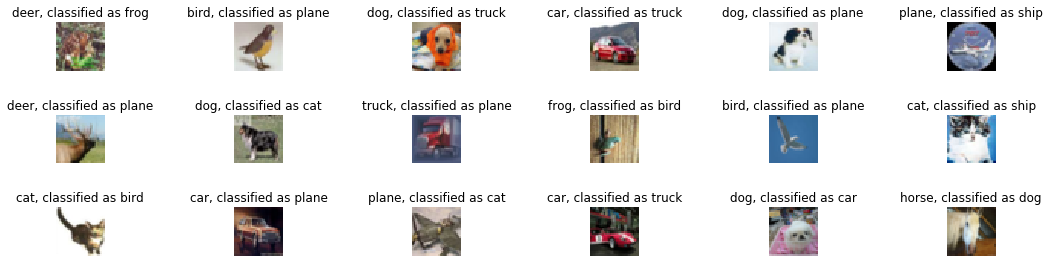

In [44]:
# Plot a few of them
plt.figure(figsize=(15,4))
perm = np.random.permutation(miss)
for i in range(18):
    im = (Xtest[perm[i]] + 1) * 127.5
    im = im.astype('int')
    label_correct = y_correct[perm[i]]
    label_pred = y_pred[perm[i]]
    
    plt.subplot(3,6,i+1)
    plt.tight_layout()
    plt.imshow(im)
    plt.axis('off')
    plt.title("{}, classified as {}".format(classes[label_correct], classes[label_pred]))
plt.show()

##  Part 21: Testing on another size

Question 27: This CNN has been trained on 32 x 32 images, can it be applied to images of another size? If not, why is this the case?

Only fully convolutional network can be trained and applied with other size of images.

Question 28: Is it possible to design a CNN that can be trained on images of one size, and then applied to an image of any size? How?

Don't add any dense layer to our model

##  Part 22: Pre-trained 2D CNNs

There are many deep 2D CNNs that have been pre-trained using the large ImageNet database. Import a pre-trained ResNet50 network from Keras applications. Show the network using `model.summary()`

Question 29: How many convolutional layers does ResNet50 have? 

ResNet-50 is a convolutional neural network that is 50 layers deep.

Question 30: How many trainable parameters does the ResNet50 network have? 

Over 23 million

Question 31: What is the size of the images that ResNet50 expects as input?

224x224

Question 32: Using the answer to question 30, explain why the second derivative is seldom used when training deep networks.

For second derivative, it requires  a lot of computation. If n values required for computation, n^2 computation is needed for getting the second derivative.

Apply the pre-trained CNN to 5 random color images that you download and copy to the cloud machine. Are the predictions correct? How certain is the network of each image class?

These pre-trained networks can be fine tuned to your specific data, and normally only the last layers need to be re-trained, but it will still be too time consuming to do in this laboration.

See https://keras.io/applications/#resnet

Useful functions

`image.load_img` in keras.preprocessing

`image.img_to_array` in keras.preprocessing

`ResNet50` in keras.applications.resnet50

`preprocess_input` in keras.applications.resnet50

`decode_predictions` in keras.applications.resnet50

`expand_dims` in numpy


In [3]:
# Your code for using pre-trained ResNet 50 on 5 color images of your choice
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

model = ResNet50(weights='imagenet')
import os

folder_path="images/"

for file in os.listdir(folder_path):
    img_path = folder_path+file
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    # decode the results into a list of tuples (class, description, probability)
    # (one such list for each sample in the batch)
    print("Object:",file)
    print('\n Predicted:', decode_predictions(preds, top=3)[0])
    print("\n")

Object: phone.png

 Predicted: [('n06359193', 'web_site', 0.2263002), ('n04152593', 'screen', 0.19669347), ('n03584254', 'iPod', 0.13491485)]


Object: computer.jpg

 Predicted: [('n03180011', 'desktop_computer', 0.7387453), ('n04404412', 'television', 0.13783683), ('n04152593', 'screen', 0.05256923)]


Object: watch.jpg

 Predicted: [('n04328186', 'stopwatch', 0.47718865), ('n02708093', 'analog_clock', 0.46471334), ('n03197337', 'digital_watch', 0.04699991)]


Object: keyboard.jpg

 Predicted: [('n03085013', 'computer_keyboard', 0.60035396), ('n04264628', 'space_bar', 0.2929298), ('n04505470', 'typewriter_keyboard', 0.067439355)]


Object: cup.jpg

 Predicted: [('n07930864', 'cup', 0.7712773), ('n03063599', 'coffee_mug', 0.2047925), ('n03950228', 'pitcher', 0.007292855)]


